In [56]:
import os
import numpy as np
from imageio.v2 import imread
from scipy.io import loadmat
import random
import time
import itertools
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16,MobileNetV2
from keras import layers, models, optimizers
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,GlobalAveragePooling2D, Dropout
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import pandas as pd
from keras.callbacks import EarlyStopping

import torch.nn as nn
from torchvision import models
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


In [57]:
original_path = "C:/Users/asent/Desktop/S4_Barcelona/FaceDetection/Lab4/"
imgPath     = original_path + "TRAINING/"
Saving_folder = original_path + "Cropped/"
Training_rate   = 0.75
validation_rate = 0.25

In [58]:
challenge = loadmat('AGC_Challenge3_Training.mat')
data      = challenge['AGC_Challenge3_TRAINING'][0]
data_extended = []

for item in data:
    label = item[0][0][0]
    image = item[1][0]
    # Handling faces, assuming faces data is in item[2]
    faces = item[2] if len(item[2]) > 0 else []
    data_extended.append([label, image, faces])

# Convert the extended list to a DataFrame
df_extended = pd.DataFrame(data_extended, columns=['Label', 'Image', 'Faces'])

# Split the Dataset into Training Dataset and Validation Dataset
train_df, val_df = train_test_split(df_extended, test_size=validation_rate, random_state=42, stratify=df_extended['Label'])

In [59]:
def normalize_and_crop_faces(df, directory, display =False):
    
    #-- parameters for the grid plot
    nDisplay = 12
    ncols = 3  # for example, change as needed
    nrows = 4
    imgDisplayed = 0
    plt.figure(figsize=(9,12))  # Adjust the size as needed

    cropped_and_normalized_faces = []
    labels=[]
    image_name=[]
    for index, row in df.iterrows():
        filepath = os.path.join(directory, row['Image'])
        img = cv.imread(filepath)

        if img is not None:
            faces = row['Faces']
                
            if len(faces) > 0:
                #-- Handle images with detected faces
                
                # Crop, normalize, and collect faces if detected
                for (x1, y1, x2, y2) in faces:
                    face = img[y1:y2, x1:x2]
                    face_resized = cv.resize(face, (224, 224))
                    face_gray = cv.cvtColor(face_resized, cv.COLOR_BGR2GRAY)
                    face_normalized = face_gray / 255.0
                    # face_normalized = face_resized / 255.0
                    cropped_and_normalized_faces.append(face_normalized)
                    labels.append(row['Label'])
                    image_name.append(row['Image'])
                    if imgDisplayed<nDisplay and display:
                        face_rgb = cv.cvtColor(face_resized, cv.COLOR_BGR2RGB)
                        plt.subplot(nrows, ncols, imgDisplayed+1)  # Create a subplot for each image
                        imgDisplayed +=1
                        plt.imshow(face_rgb)
                        plt.title("Face "+str(row['Image'])+" with ID = "+ str(row['Label']))
                        plt.axis('off')
                        
            else:
                #-- Handle images without detected faces
                # Resize the original image and normalize
                img_resized = cv.resize(img, (224, 224))  # Ensure the resized image matches model input
                img_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)
                img_normalized = img_gray / 255.0
                # img_normalized = img_resized / 255.0
                cropped_and_normalized_faces.append(img_normalized)
                labels.append(row['Label'])
                image_name.append(row['Image'])


    plt.show()
    return np.array(cropped_and_normalized_faces), np.array(labels),np.array(image_name)
    # return cropped_and_normalized_faces, labels
  

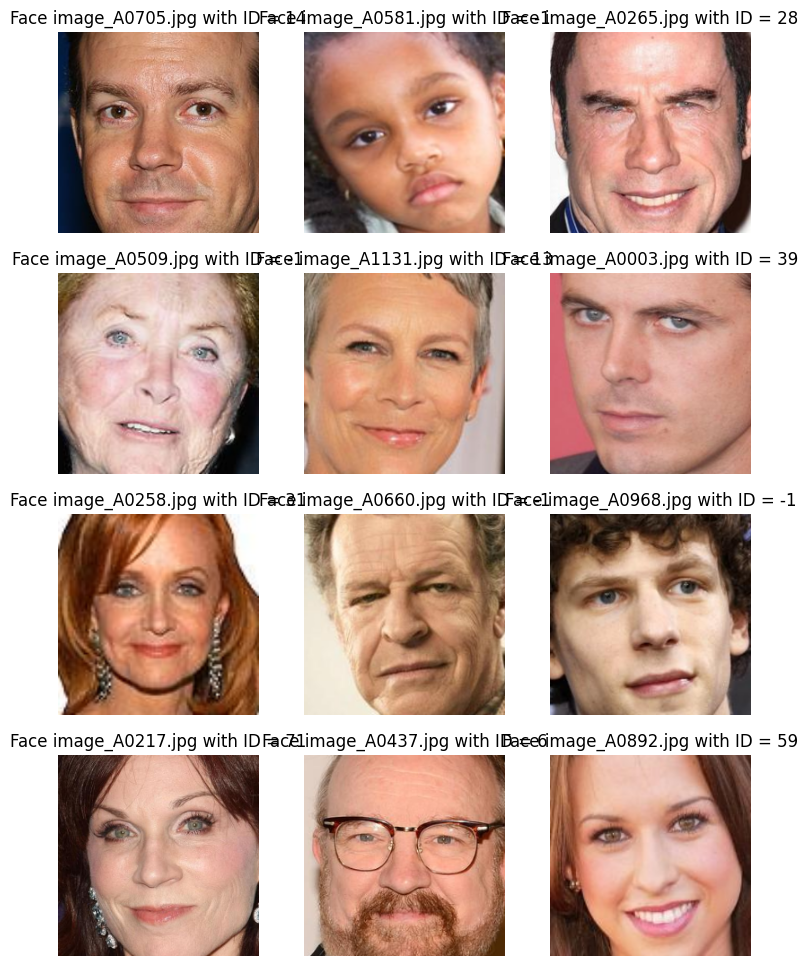

<Figure size 900x1200 with 0 Axes>

In [60]:
##--TEST
Training_cropped_faces, Training_face_labels ,image__= normalize_and_crop_faces(train_df, imgPath, display=True)
Validation_cropped_faces, Validation_face_labels,ok = normalize_and_crop_faces(val_df, imgPath)


In [61]:
##additionnal_functions

def count_version(label_val):
    count_ = [0 for i in range(81)]
    for k in range(len(label_val)):
        label = label_val[k]
        if label ==-1:
            count_[0] +=1
        else:
            count_[label] +=1
    return(count_)

def Save_detection(img,M,img_name):
    """draw the rectangle on the original image and save the image in the saving folder"""
    # M2 = MyFaceDetectionFunction(img)
    
    for rect in M:
        cv.rectangle(img,(rect[0],rect[1]),(rect[2],rect[3]),(0,0,255),4)
        
    # for rect in M2:
    #     cv.rectangle(img,(rect[0],rect[1]),(rect[2],rect[3]),(0,255,0),4)
    cv.imwrite(Saving_folder + img_name, img)
    # cv.imshow(img)
    

In [62]:
#-- Face detection
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_alt.xml')

#parameter for the detection
scaleFactor  = 1.05
minNeighbors = 6
minsize      = 100
# maxsize      = 700

def MyFaceDetectionFunction(img): #from lab 1
    frame_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)

    #-- Detect faces
    faces = face_cascade.detectMultiScale(
        frame_gray, 
        scaleFactor  = scaleFactor, 
        minNeighbors = minNeighbors, 
        minSize      = (minsize, minsize),
        # maxSize      = (maxsize, maxsize)
    )
    return faces

def select_two_biggest_faces(faces):
    areas = []
    M =[]
    for (x,y,w,h) in faces:
        x1 = x
        y1 = y
        x2 = x1 + w 
        y2 = y1 + h
        M.append([x1,y1,x2,y2])
        areas.append(w*h)
        
    if len(M)>2:
        first_face = 0
        second_face = 1
        if areas[first_face]<areas[second_face]: #check if the biggest face is on index 2, then swap index
            first_face, second_face = 1, 0
        for j in range(2,len(M)):
            if areas[j]>areas[first_face]:
                second_face = first_face
                first_face  = j
            elif areas[j]> areas[second_face]:
                second_face = j
        M = [M[first_face],M[second_face]]
    return M

def detect_crop_and_normalize_image(img,im):
    # We apply face detection
    facesDetected = MyFaceDetectionFunction(img)

    # We select the two biggest faces
    faces = select_two_biggest_faces(facesDetected)
    cropped_and_normalized_faces =[]
    
    have_a_face = False
    # Save_detection(img,faces,im)
    if len(faces) > 0:
        #-- Handle images with detected faces
        have_a_face = True
        # Crop, normalize, and collect faces if detected
        for (x1, y1, x2, y2) in faces:
            face = img[y1:y2, x1:x2]
            img_resized = cv.resize(face, (224, 224))
            face_gray = cv.cvtColor(img_resized, cv.COLOR_BGR2GRAY)
            face_normalized = face_gray / 255.0
            face_with_channel = np.expand_dims(face_normalized, axis=-1)

            cropped_and_normalized_faces.append(face_with_channel)
            # cv.imwrite(Saving_folder + im, img_resized)
                    
    return cropped_and_normalized_faces,have_a_face

In [63]:
#Parameters
epochs = 10
nb_classes = 81
batch = 8



In [64]:
#Model functions
def printParameters(model):
    total_params = model.count_params()
    print("The model contain this number of parameters : ", total_params)

def fitModel(model,x,y,x_val,y_val):
    history = model.fit(
        x,
        y,
        epochs=epochs,
        validation_data=(x_val, y_val),
        batch_size=batch
    )
    return history

def compileModel(model):
    model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    return model

def augment_image(image):
    """
    Apply random transformations to a single image to augment it.
    The input image is expected to be a NumPy array of shape (224, 224, 1).
    """
    # Convert single image to batch format by adding an extra dimension
    image_batch = np.expand_dims(image, axis=0)

    # Create an ImageDataGenerator instance for augmentation
    augmenter = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented images (here, we generate a single one)
    augmented_image = next(augmenter.flow(image_batch, batch_size=5))

    # Remove batch dimension and return the augmented image
    return augmented_image[0]

def augment_dataset(X, y, augmentation_factor=5):
    """
    Augment a dataset of images X with labels y, repeating the process 'augmentation_factor' times.
    Each original image will have 'augmentation_factor' augmented versions in the new dataset.
    """
    X_augmented = []
    y_augmented = []

    for i in range(len(X)):
        # Original image and label
        X_augmented.append(X[i])
        y_augmented.append(y[i])

        # Generate augmented images
        for _ in range(augmentation_factor):
            augmented_image = augment_image(X[i])
            X_augmented.append(augmented_image)
            y_augmented.append(y[i])  # Keep the same label for the augmented image

    return np.array(X_augmented), np.array(y_augmented)

def preprocessingData(Training_cropped_faces,Training_face_labels,Validation_cropped_faces,Validation_face_labels):
    Training_face_labels = np.where(Training_face_labels == -1, 0, Training_face_labels)
    Validation_face_labels = np.where(Validation_face_labels == -1, 0, Validation_face_labels)
    
    
    x = np.array(Training_cropped_faces).reshape(-1, 224, 224, 1)  # Reshape for a single color channel
    y = np.array(Training_face_labels)

    x, y = augment_dataset(x, y, 1)
    y = to_categorical(y,num_classes=nb_classes)
    # Encode validation labels (this step depends on how you've implemented label encoding)
    x_val = np.array(Validation_cropped_faces).reshape(-1, 224, 224, 1)
    y_val = Validation_face_labels
    
    y_val = to_categorical(y_val,num_classes=nb_classes)  # Ensure this matches the number of classes, 81 in your model

    return x,y,x_val,y_val



In [65]:
################# STEFAN MODEL ##########################
def train_stefan_model():
    def create_custom_model(input_shape):
        inputs = Input(shape=input_shape)
        
        # Convolutional block 1
        x = Conv2D(16, (3, 3), activation='relu')(inputs)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        # Convolutional block 2
        x = Conv2D(32, (3, 3), activation='relu')(x)
        # x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Conv2D(32, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        # Flatten and classification
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = Dense(10, activation='relu')(x)
        
        outputs = Dense(nb_classes, activation='softmax')(x)  

        my_FRmodel = Model(inputs=inputs, outputs=outputs)
        return my_FRmodel

    model = create_custom_model((224, 224, 1))

    x,y,x_val,y_val = preprocessingData(Training_cropped_faces,Training_face_labels,Validation_cropped_faces,Validation_face_labels)

    model = compileModel(model)
    printParameters(model)
    # history = fitModel(model,x,y,x_val,y_val)
    # printAccuracyByEpoch(history)
        
    return model

model = train_stefan_model()
#change name otherwise it erases the previous file
model.save('modelV3.h5')
 

The model contain this number of parameters :  913829
Epoch 1/10
231/231 [==============================] - 31s 123ms/step - loss: 2.5714 - accuracy: 0.5840 - val_loss: 2.2066 - val_accuracy: 0.5960
Epoch 2/10
231/231 [==============================] - 29s 127ms/step - loss: 2.1959 - accuracy: 0.5937 - val_loss: 2.1322 - val_accuracy: 0.5960
Epoch 3/10
231/231 [==============================] - 28s 120ms/step - loss: 2.0870 - accuracy: 0.5937 - val_loss: 2.0836 - val_accuracy: 0.5960
Epoch 4/10
231/231 [==============================] - 26s 111ms/step - loss: 2.0464 - accuracy: 0.5937 - val_loss: 2.1207 - val_accuracy: 0.5960
Epoch 5/10
231/231 [==============================] - 25s 107ms/step - loss: 1.9881 - accuracy: 0.5937 - val_loss: 2.1414 - val_accuracy: 0.5960
Epoch 6/10
231/231 [==============================] - 26s 115ms/step - loss: 1.9188 - accuracy: 0.5953 - val_loss: 2.1801 - val_accuracy: 0.5894
Epoch 7/10
231/231 [==============================] - 27s 116ms/step - loss:

c:\Users\asent\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
#################KARINA MODEL##################
def train_Karina_model():
  # Define CNN model architecture
  def create_custom_model(input_shape):
      inputs = Input(shape=input_shape)
      x = Conv2D(16, (3, 3), activation='relu')(inputs)
      x = MaxPooling2D((2, 2))(x)
      # Convolutional block
      x = Conv2D(32, (3, 3), activation='relu')(x)
      x = MaxPooling2D((2, 2))(x)
      # Convolutional block
      x = Conv2D(64, (3, 3), activation='relu')(x)
      x = MaxPooling2D((2, 2))(x)
      
      # Flatten and classification
      x = Flatten()(x)
      x = Dropout(0.5)(x)
      x = Dense(256, activation='relu')(x) #Numero de neuronas 512
     
      # x = GlobalAveragePooling2D()(x)
      # x = Dense(256, activation='relu')(x)
      
      outputs = Dense(81, activation='softmax')(x)
      my_FRmodel = Model(inputs=inputs, outputs=outputs)
      return my_FRmodel

  model = create_custom_model((224, 224, 1))
  printParameters(model)

  x,y,x_val,y_val = preprocessingData(Training_cropped_faces,Training_face_labels,Validation_cropped_faces,Validation_face_labels)

  model = compileModel(model)
  printParameters(model)
  # history = fitModel(model,x,y,x_val,y_val)
  return model

# model = train_Karina_model()  

In [67]:

model_path = 'modelV5.h5'
model = load_model(model_path)

total_params = model.count_params()
print("The model contain ",total_params, " parameters")


# Get the size in MB
size_model = os.path.getsize(model_path)/ (1024*1024)  
print(f"Size of the model is : {size_model:.2f} MB")

# # Summary to check total params and ensure it's under 1 million
# my_FRmodel.summary()

The model contain  913829  parameters
Size of the model is : 10.51 MB


In [68]:
def my_face_prediction_function(img,im,model):
    cropped_and_normalized_faces,have_a_face = detect_crop_and_normalize_image(img,im)
    
    if not have_a_face:
        return -1
    
    for face in cropped_and_normalized_faces:
        face_batch = np.expand_dims(face, axis=0)  # format the model (1, 224, 224, 1)
        predictions = model.predict(face_batch,verbose=0)
        predicted_class = np.argmax(predictions, axis=1)
        
        if predicted_class !=0:
            return predicted_class
    return -1
       
  
  
# im = "image_A0011.jpg"
# img = cv.imread(imgPath+im)

# prediction = my_face_prediction_function(model,img)
# print(prediction)


TEST THE MODEL

In [69]:
def CHALL_AGC_ComputeRecognScores(auto_ids, true_ids):
    #   Compute face recognition score
    #
    #   INPUTS
    #     - AutomSTR: The results of the automatic face
    #     recognition algorithm, stored as an integer
    #
    #     - AGC_Challenge_STR: The ground truth ids
    #
    #   OUTPUT
    #     - FR_score:     The final recognition score
    #
    #   --------------------------------------------------------------------
    #   AGC Challenge
    #   Universitat Pompeu Fabra
    #

    if len(auto_ids) != len(true_ids):
        assert ('Inputs must be of the same len');

    f_beta = 1
    res_list = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nTP = len([i for i in res_list if auto_ids[i] == true_ids[i]])

    res_list = list(filter(lambda x: auto_ids[x] != -1, range(len(auto_ids))))

    nFP = len([i for i in res_list if auto_ids[i] != true_ids[i]])

    res_list_auto_ids = list(filter(lambda x: auto_ids[x] == -1, range(len(auto_ids))))
    res_list_true_ids = list(filter(lambda x: true_ids[x] != -1, range(len(true_ids))))

    nFN = len(set(res_list_auto_ids).intersection(res_list_true_ids))

    FR_score = (1 + f_beta ** 2) * nTP / ((1 + f_beta ** 2) * nTP + f_beta ** 2 * nFN + nFP)

    return FR_score,nTP,res_list
 
def get_image_id(img_name, image_names, ids):
    index = image_names.index(img_name)
    image_id = ids[index]
    return image_id
     
def Face_Recognition_Challenge():
    # Basic script for Face Recognition Challenge
    # --------------------------------------------------------------------
    # AGC Challenge
    # Universitat Pompeu Fabra

    # Load challenge Training data
    dir_challenge3 = original_path
    AGC_Challenge3_TRAINING = loadmat(dir_challenge3 + "AGC_Challenge3_Training.mat")
    AGC_Challenge3_TRAINING = np.squeeze(AGC_Challenge3_TRAINING['AGC_Challenge3_TRAINING'])

    imageName = AGC_Challenge3_TRAINING['imageName']
    imageName = list(itertools.chain.from_iterable(imageName))

    ids = list(AGC_Challenge3_TRAINING['id'])
    ids = np.concatenate(ids).ravel().tolist()

    faceBox = AGC_Challenge3_TRAINING['faceBox']
    faceBox = list(itertools.chain.from_iterable(faceBox))


    # Initialize results structure
    AutoRecognSTR = []

    # Initialize timer accumulator
    total_time = 0

    # Load your FRModel
    my_FRmodel = model
    

    # cv.imshow("okkkk",frame_gray)
    # cv.waitKey(0)  # Attendre indéfiniment qu'une touche soit pressée
    # cv.destroyAllWindows()  # Fermer toutes les fenêtres OpenCV ouvertes
    # print("#########")
    for idx, im in enumerate(imageName):

        A = cv.imread(imgPath + im)
            

        try:
            print(f"Image number : {idx}", end='\r')  
            ti = time.time()
            # Timer on
            ###############################################################
            # Your face recognition function goes here.It must accept 2 input parameters:

            # 1. the input image A
            # 2. the recognition model

            # and must return a single integer number as output, which can be:

            # a) A number between 1 and 80 (representing one of the identities in the training set)
            # b) A "-1" indicating that none of the 80 users is present in the input image
            autom_id = my_face_prediction_function(A,im, my_FRmodel)
            tt = time.time() - ti
            total_time = total_time + tt
        except:
            # If the face recognition function fails, it will be assumed that no user was detected for his input image
            autom_id = random.randint(-1, 80)

        AutoRecognSTR.append(autom_id)

    FR_score ,nTP, res_list= CHALL_AGC_ComputeRecognScores(AutoRecognSTR, ids)
    _, rem = divmod(total_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print('F1-score: %.2f, Total time: %2d m %.2f s' % (100 * FR_score, int(minutes), seconds))


In [70]:
Face_Recognition_Challenge()

F1-score: 4.25, Total time:  1 m 35.49 s
